In [22]:
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import numpy as np
import tensorflow_datasets as tfds

# Load Datasets

In [23]:
beans_dataset, beans_info = tfds.load(name='beans', with_info=True, as_supervised=True, split=['train','test','validation'])

In [24]:
builder = tfds.ImageFolder('/Users/szymon/Desktop/AiRoll/data/')

In [25]:
ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)

## Display dataset

In [26]:
def preprocessing(image, label):
    image /= 255.0

    return tf.image.resize(image,[224,224]), tf.one_hot(label, 7)

In [27]:
datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,validation_split=0.2)
train_generator = datagen.flow_from_directory(
    directory=r"../data/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    directory=r"../data/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="validation"
)

Found 669 images belonging to 7 classes.
Found 165 images belonging to 7 classes.


In [28]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [29]:
from itertools import count

a = train_generator.classes.flatten().tolist()
dist_dict = {}
for label,number in train_generator.class_indices.items():
    dist_dict[label] = a.count(number)
dist_dict

{'closeUp': 89,
 'detail': 45,
 'extremeLongShot': 85,
 'fullShot': 70,
 'longShot': 97,
 'mediumCloseUp': 127,
 'mediumShot': 156}

In [30]:
train_generator.class_indices.items()

dict_items([('closeUp', 0), ('detail', 1), ('extremeLongShot', 2), ('fullShot', 3), ('longShot', 4), ('mediumCloseUp', 5), ('mediumShot', 6)])

(32, 224, 224, 3)


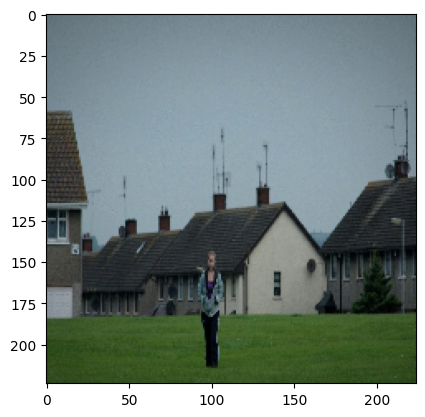

(32, 224, 224, 3)


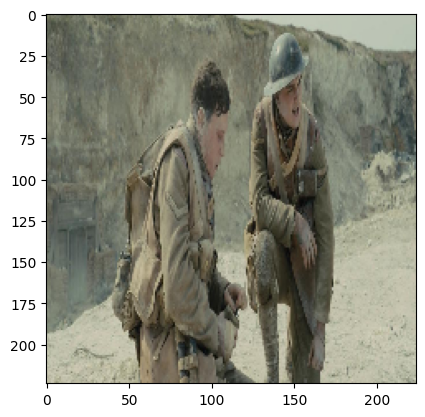

(32, 224, 224, 3)


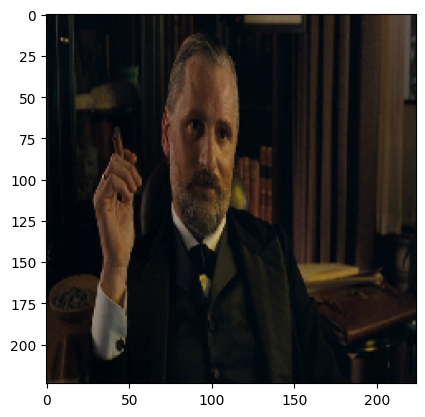

(32, 224, 224, 3)


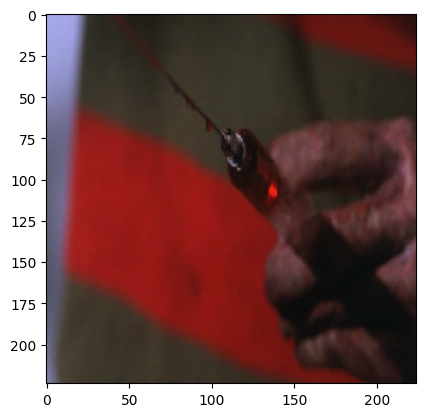

(32, 224, 224, 3)


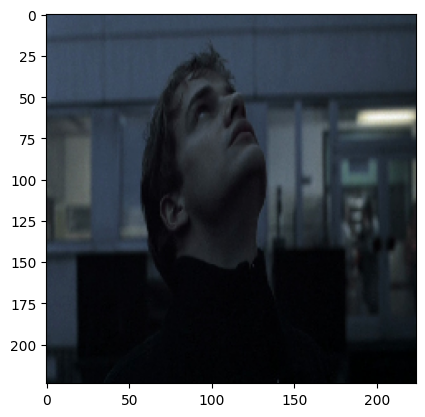

In [31]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [32]:
train_generator.class_indices

{'closeUp': 0,
 'detail': 1,
 'extremeLongShot': 2,
 'fullShot': 3,
 'longShot': 4,
 'mediumCloseUp': 5,
 'mediumShot': 6}

# Model Compilation

In [33]:
mobilenet_v2 = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

In [34]:
## pre-trained layers
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))

In [35]:
# To ensure that TensorFlow does not retrain the mobile_net_layers, use this code:
mobile_net_layers.trainable = False

In [36]:
# Build the neural network and add custom layers.
neural_net = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(7,activation='softmax')
])

In [37]:
neural_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7014      
                                                                 
Total params: 25,622,863
Trainable params: 7,014
Non-trainable params: 25,615,849
_________________________________________________________________


In [38]:
#Compile the deep neural network using the following code
learning_rate = 0.1
epochs=100
decay_rate = learning_rate / epochs
neural_net.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.95,momentum=0.8, decay=learning_rate/epochs),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
)

In [41]:
model_fit = neural_net.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_precision', restore_best_weights=True)
        ],)      

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 135.5940 - precision_2: 0.5725 - recall_2: 0.5725

2022-09-30 14:12:10.264998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 9s 410ms/step - loss: 135.5940 - precision_2: 0.5725 - recall_2: 0.5725 - val_loss: 147.7611 - val_precision_2: 0.5576 - val_recall_2: 0.5576
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 128.8458 - precision_2: 0.6129 - recall_2: 0.6129WARNING:tensorflow:Early stopping conditioned on metric `val_prec` which is not available. Available metrics are: loss,precision_2,recall_2,val_loss,val_precision_2,val_recall_2


21/21 [==============================] - 8s 370ms/step - loss: 128.8458 - precision_2: 0.6129 - recall_2: 0.6129 - val_loss: 154.2439 - val_precision_2: 0.5758 - val_recall_2: 0.5758
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 86.3714 - precision_2: 0.6682 - recall_2: 0.6682